# Comparison between Concrete Dropout and Gaussian-prior BNN

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import gc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


# Create two-moons dataset

In [2]:
from sklearn.datasets import make_moons
x_train, y_train = make_moons(n_samples = 5000, noise = 0.20)
x_test, y_test = make_moons(n_samples = 2000, noise = 0.20)
y_test = y_test.astype(np.float32)
y_train = y_train.astype(np.float32)


# Create model using Concrete Dropout

In [3]:
import tensorflow.keras.backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Lambda, Wrapper
from tensorflow.python.ops import random_ops

# Keras layer wrapper to implement Concrete Dropout
class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input Dense layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers which have 2D
    kernels, not just `Dense`. However, Conv2D layers require different
    weighing of the regulariser (use SpatialConcreteDropout instead).
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)

        # initialise regulariser / prior KL term
        assert len(input_shape) == 2, 'this wrapper only supports Dense layers'
        self.input_dim = np.prod(input_shape[-1])  # we drop only last dim

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        #unif_noise = random_ops.random_uniform(shape = K.shape(x), dtype=x.dtype)
        p = K.sigmoid(self.p_logit[0])
        drop_prob = (
            K.log(p + eps)
            - K.log(1. - p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        p = K.sigmoid(self.p_logit[0])
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - p)
        dropout_regularizer = p * K.log(p)
        dropout_regularizer += (1. - p) * K.log(1. - p)
        dropout_regularizer *= self.dropout_regularizer * self.input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

def makeModel(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu):
    batch_size = 100
    Nepochs = 100
    train_size = len(x_train)
    L = x_train.shape[1]

    lengthscale = 1e-4
    wd = lengthscale**2/train_size
    dd = 2./train_size
    layers = [200, 100, 50, 5]

    x_in = tf.keras.layers.Input(shape = (L,))
    x = x_in
    for il, l in enumerate(layers):
        x = ConcreteDropout(tf.keras.layers.Dense(l, activation = activation), weight_regularizer = wd, dropout_regularizer = dd)(x)
    if heteroscedatic:
        m = ConcreteDropout(tf.keras.layers.Dense(2, activation = None), weight_regularizer = wd, dropout_regularizer = dd)(x)
    else:
        m = ConcreteDropout(tf.keras.layers.Dense(1, activation = None), weight_regularizer = wd, dropout_regularizer = dd)(x)

    def homoloss(y_true, y_pred):
        mean_ = y_pred[:,0]
        y_ = y_true[:,0]
        return tf.square(y_ - mean_)
    def heteroloss(y_true, y_pred):
        mean_ = y_pred[:,0]
        logvar_ = y_pred[:,1]
        prec_ = tf.exp(-logvar_)
        y_ = y_true[:,0]
        return prec_*tf.square(y_ - mean_) + logvar_

    model = tf.keras.Model(x_in, m)
    if heteroscedatic:
        model.compile(loss = heteroloss, optimizer = tf.keras.optimizers.Adam(1e-3), metrics = [])
    else:
        model.compile(loss = homoloss, optimizer = tf.keras.optimizers.Adam(1e-3), metrics = [])
    history = model.fit(x_train, y_train,
              epochs = Nepochs,
              batch_size = batch_size,
              shuffle = True,
              validation_data = (x_test, y_test),
              callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'loss',
                                                            min_delta = 0,
                                                            patience = 5,
                                                            verbose = 1,
                                                            mode = 'auto',
                                                            restore_best_weights = True)])
    p_list = [tf.nn.sigmoid(x) for x in model.trainable_weights if "p_logit" in x.name]
    print("Dropout probabilities:", p_list)
    return model, history


def getMeanStd(model, x_test, Npred = 50):
    pred_m = np.zeros( (len(x_test),) )
    pred_s = np.zeros( (len(x_test),) )
    for i in range(0, Npred):
        tmp = model.predict(x_test)[:,0]
        pred_m += tmp
        pred_s += tmp**2
        del tmp
        gc.collect()
    pred_m /= float(Npred)
    pred_s /= float(Npred)
    pred_s -= pred_m**2
    pred_s[pred_s <= 0] = 1e-6
    pred_s = np.sqrt(pred_s)
        
    return pred_m, pred_s

def getMeanStdH(model, x_test, Npred = 50):
    pred_m = np.zeros( (len(x_test),) )
    pred_s = np.zeros( (len(x_test),) )
    pred_s_ale = 0.5*np.exp(model.predict(x_test)[:,1])
    for i in range(0, Npred):
        tmp = model.predict(x_test)[:,0]
        pred_m += tmp
        pred_s += tmp**2
        del tmp
        gc.collect()
    pred_m /= float(Npred)
    pred_s /= float(Npred)
    pred_s -= pred_m**2
    pred_s[pred_s <= 0] = 1e-6
    pred_s = np.sqrt(pred_s)
    pred_s = np.sqrt(pred_s_ale**2 + pred_s**2)
        
    return pred_m, pred_s



In [4]:
hetero_model, hetero_model_h = makeModel(x_train, y_train, heteroscedatic = True, activation = tf.nn.relu)
homo_model, homo_model_h = makeModel(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu)

Train on 5000 samples, validate on 2000 samples
Epoch 1/100
5000/5000 [==============================] - 12s 2ms/sample - loss: 0.3546 - val_loss: 0.0072
Epoch 2/100
5000/5000 [==============================] - 1s 215us/sample - loss: -0.4657 - val_loss: -0.9099
Epoch 3/100
5000/5000 [==============================] - 1s 208us/sample - loss: -1.0857 - val_loss: -1.2027
Epoch 4/100
5000/5000 [==============================] - 1s 215us/sample - loss: -1.3091 - val_loss: -1.3995
Epoch 5/100
5000/5000 [==============================] - 1s 195us/sample - loss: -1.4806 - val_loss: -1.4819
Epoch 6/100
5000/5000 [==============================] - 1s 255us/sample - loss: -1.5938 - val_loss: -1.5896
Epoch 7/100
5000/5000 [==============================] - 1s 202us/sample - loss: -1.6775 - val_loss: -1.6491
Epoch 8/100
5000/5000 [==============================] - 1s 179us/sample - loss: -1.8148 - val_loss: -1.8258
Epoch 9/100
5000/5000 [==============================] - 1s 213us/sample - loss: -1

Epoch 3/100
5000/5000 [==============================] - 1s 151us/sample - loss: 0.0976 - val_loss: 0.0955
Epoch 4/100
5000/5000 [==============================] - 1s 156us/sample - loss: 0.0873 - val_loss: 0.0862
Epoch 5/100
5000/5000 [==============================] - 1s 185us/sample - loss: 0.0834 - val_loss: 0.0769
Epoch 6/100
5000/5000 [==============================] - 1s 201us/sample - loss: 0.0765 - val_loss: 0.0799
Epoch 7/100
5000/5000 [==============================] - 1s 211us/sample - loss: 0.0719 - val_loss: 0.0726
Epoch 8/100
5000/5000 [==============================] - 1s 180us/sample - loss: 0.0701 - val_loss: 0.0712
Epoch 9/100
5000/5000 [==============================] - 1s 179us/sample - loss: 0.0690 - val_loss: 0.0657
Epoch 10/100
5000/5000 [==============================] - 1s 174us/sample - loss: 0.0647 - val_loss: 0.0637
Epoch 11/100
5000/5000 [==============================] - 1s 217us/sample - loss: 0.0601 - val_loss: 0.0658
Epoch 12/100
5000/5000 [===========

# Create Gaussian-prior BNN

In [5]:

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.exp(1e-3)-1.0)
    return tf.keras.Sequential([tfp.layers.VariableLayer(2*n, initializer = 'zeros', trainable = True, dtype=dtype),
                       tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
                           tfp.distributions.Normal(loc=t[..., :n], scale=1e-4+tf.math.softplus(c + 1e-3*t[..., n:])),
                           reinterpreted_batch_ndims=1))
    ])

def prior_fixed(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([tfp.layers.VariableLayer(n, initializer = 'zeros', trainable = False, dtype=dtype),
                                tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
                                tfp.distributions.Normal(loc = t, scale = 1.0), reinterpreted_batch_ndims = 1))
                                ])

def makeModelBNN(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu):
    batch_size = 100
    Nepochs = 100
    train_size = len(x_train)
    L = x_train.shape[1]

    layers = [200, 100, 50, 5]

    x_in = tf.keras.layers.Input(shape = (L,))
    x = x_in
    for il, l in enumerate(layers):
        x = tfp.layers.DenseVariational(l,
                                        posterior_mean_field,
                                        prior_fixed,
                                        kl_weight = 1.0/train_size,
                                        kl_use_exact = True,
                                        activation = activation,
                                        )(x)
    n_out = 1
    if heteroscedatic:
        n_out = 2
    x = tfp.layers.DenseVariational(n_out,
                                        posterior_mean_field,
                                        prior_fixed,
                                        kl_weight = 1.0/train_size,
                                        kl_use_exact = True,
                                        activation = None,
                                        )(x)
    if heteroscedatic:
        c = np.log(np.exp(1e-3)-1.0)
        x = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t[...,:1],
                                                                    scale = 1e-4 + tf.math.softplus(c+1e-3*t[...,1:])
                                                                        ))(x)
    else:
        x = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc = t,
                                                                        scale = 1e-4
                                                                        ))(x)

    nll = lambda y_true, y_pred: -tf.reduce_mean(y_pred.log_prob(y_true))
    model = tf.keras.Model(x_in, x)
    model.compile(loss = nll, optimizer = tf.keras.optimizers.Adam(1e-3), metrics = [])
    history = model.fit(x_train, y_train,
              epochs = Nepochs,
              batch_size = batch_size,
              shuffle = True,
              validation_data = (x_test, y_test),
              callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'loss',
                                                            min_delta = 0,
                                                            patience = 5,
                                                            verbose = 1,
                                                            mode = 'auto',
                                                            restore_best_weights = True)])
    return model, history

def getMeanStdBNN(model, x_test, Npred = 50):
    pred_m = np.zeros( (len(x_test),) )
    pred_s = np.zeros( (len(x_test),) )
    for i in range(0, Npred):
        tmp = model.predict(x_test)[:,0]
        pred_m += tmp
        pred_s += tmp**2
        del tmp
        gc.collect()
    pred_m /= float(Npred)
    pred_s /= float(Npred)
    pred_s -= pred_m**2
    pred_s[pred_s <= 0] = 1e-6
    pred_s = np.sqrt(pred_s)
    return pred_m, pred_s

In [6]:
hetero_model_bnn, hetero_model_bnn_h = makeModelBNN(x_train, y_train, heteroscedatic = True, activation = tf.nn.relu)
homo_model_bnn, homo_model_bnn_h = makeModelBNN(x_train, y_train, heteroscedatic = False, activation = tf.nn.relu)

Train on 5000 samples, validate on 2000 samples
Epoch 1/100
5000/5000 [==============================] - 12s 2ms/sample - loss: 190662.8984 - val_loss: 156627.5207
Epoch 2/100
5000/5000 [==============================] - 1s 277us/sample - loss: 78919.3239 - val_loss: 46351.9391
Epoch 3/100
5000/5000 [==============================] - 1s 280us/sample - loss: 43107.9313 - val_loss: 41449.7821
Epoch 4/100
5000/5000 [==============================] - 1s 273us/sample - loss: 40561.3020 - val_loss: 40468.0811
Epoch 5/100
5000/5000 [==============================] - 1s 299us/sample - loss: 40071.2239 - val_loss: 40161.7929
Epoch 6/100
5000/5000 [==============================] - 2s 302us/sample - loss: 39790.9293 - val_loss: 39915.6177
Epoch 7/100
5000/5000 [==============================] - 1s 241us/sample - loss: 39524.6038 - val_loss: 39757.7305
Epoch 8/100
5000/5000 [==============================] - 1s 228us/sample - loss: 39400.2510 - val_loss: 39493.8313
Epoch 9/100
5000/5000 [========

5000/5000 [==============================] - 1s 267us/sample - loss: 16699.4531 - val_loss: 18835.2500
Epoch 72/100
5000/5000 [==============================] - 1s 272us/sample - loss: 16736.4694 - val_loss: 17140.0707
Epoch 73/100
5000/5000 [==============================] - 1s 241us/sample - loss: 16481.6560 - val_loss: 17075.4137
Epoch 74/100
5000/5000 [==============================] - 2s 309us/sample - loss: 16544.1174 - val_loss: 16886.7767
Epoch 75/100
5000/5000 [==============================] - 1s 277us/sample - loss: 16053.6874 - val_loss: 17353.3114
Epoch 76/100
5000/5000 [==============================] - 1s 268us/sample - loss: 16003.9281 - val_loss: 16725.7136
Epoch 77/100
5000/5000 [==============================] - 1s 264us/sample - loss: 15894.0964 - val_loss: 16580.4731
Epoch 78/100
5000/5000 [==============================] - 2s 300us/sample - loss: 15750.5862 - val_loss: 16279.5544
Epoch 79/100
5000/5000 [==============================] - 1s 271us/sample - loss: 156

# Function to do plots showing mean and uncertainties

In [7]:
def plot_contour(model, x, y, getFunction):
    # make countour
    mins = [np.min(x[:,0]), np.min(x[:,1])]
    maxs = [np.max(x[:,0]), np.max(x[:,1])]
    step = [(maxs[0] - mins[0])/50.0, (maxs[1] - mins[1])/50.0]
    bx, by = np.mgrid[mins[0]:(maxs[0]+0.5*step[0]):step[0], mins[1]:(maxs[1]+0.5*step[0]):step[1]]
    inputs = np.vstack([bx.flatten(), by.flatten()]).T
    inputs = inputs.astype(np.float32)

    pred_m, pred_s = getFunction(model, inputs, Npred = 50)
    pred_m_2d = pred_m.reshape( (-1, bx.shape[1]) )
    pred_s_2d = pred_s.reshape( (-1, bx.shape[1]) )

    # if one wants to smoothen the results
    #for data in [pred_m_2d, pred_s_2d]:
    #    data = gaussian_filter(data, 0.1)

    fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10, 8))
    cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
    contour_s = ax[0].contourf(bx, by, pred_s_2d, cmap = cmap)
    cbar_s = plt.colorbar(contour_s, ax = ax[0])
    cbar_s.ax.set_ylabel('Unc.')
    contour_m = ax[1].contourf(bx, by, pred_m_2d, cmap = cmap)
    cbar_m = plt.colorbar(contour_m, ax = ax[1])
    cbar_m.ax.set_ylabel('Mean')
    for a in [ax[0], ax[1]]:
        a.scatter(x[y == 1,0], x[y == 1,1], color = 'r', marker = 's', s = 5, label = 'y = 1')
        a.scatter(x[y == 0,0], x[y == 0,1], color = 'b', marker = 's', s = 5, label = 'y = 0')
        a.set(xlabel = 'A', ylabel = 'B', title = '')
        a.set_xlim([mins[0], maxs[0]])
        a.set_ylim([mins[1], maxs[1]])
        a.legend(frameon = True)
    ax[0].set_xlabel('')
    fig.subplots_adjust(hspace = 0)
    fig.tight_layout()
    plt.show()


# Countour for heteroscedatic Concrete Dropout model

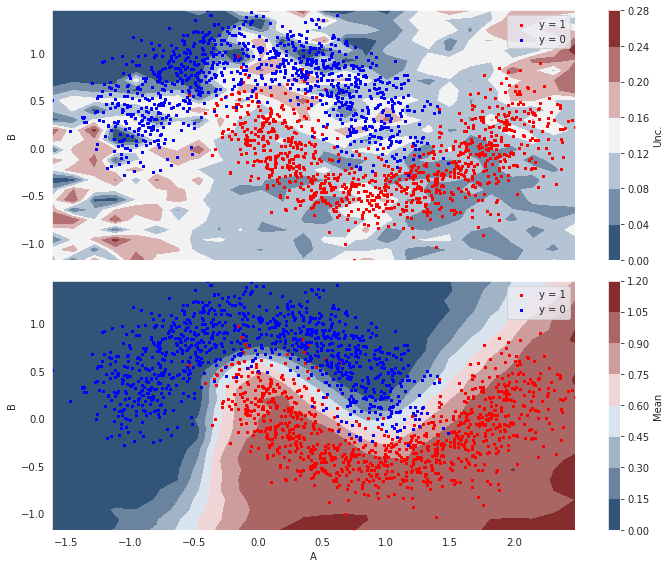

In [8]:
plot_contour(hetero_model, x_test, y_test, getFunction = getMeanStdH)


# Contour for homoscedatic Concrete Dropout model

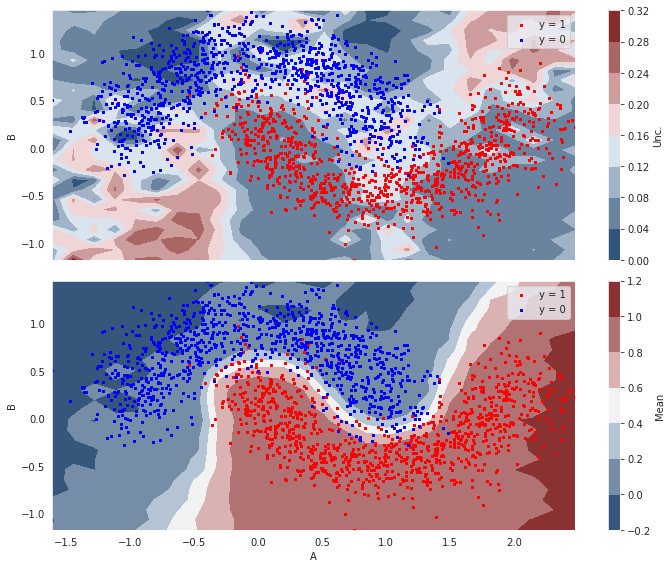

In [9]:
plot_contour(homo_model, x_test, y_test, getFunction = getMeanStd)


# Contour for heteroscedatic Gaussian-prior BNN model

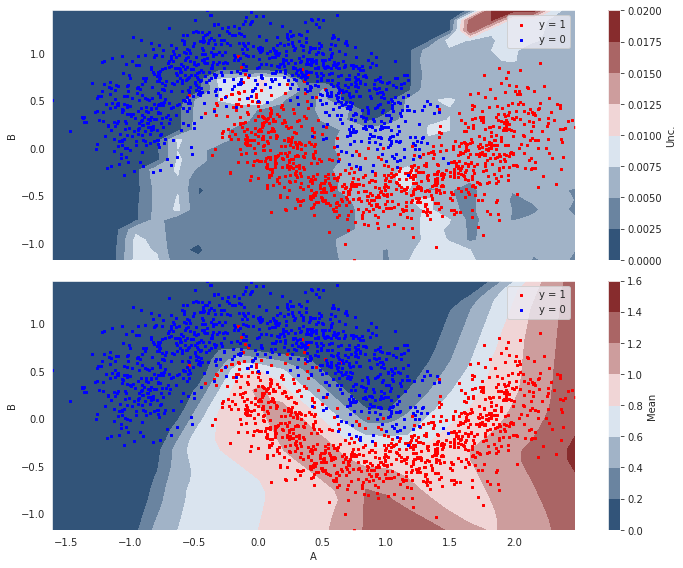

In [10]:
plot_contour(hetero_model_bnn, x_test, y_test, getFunction = getMeanStdBNN)


# Contour for homoscedatic Gaussian-prior BNN model

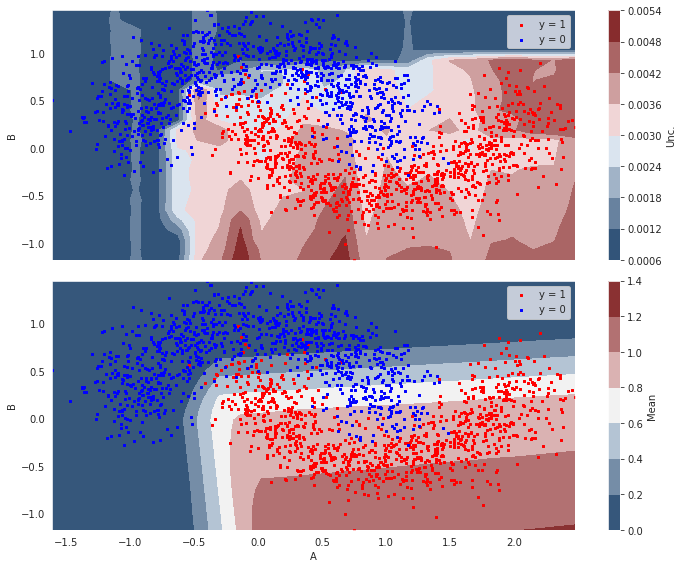

In [11]:
plot_contour(homo_model_bnn, x_test, y_test, getFunction = getMeanStdBNN)
